In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [5]:
import urllib.request

print('Downloading data')
my_stocks = ['AAPL','BA','FB','GILD','REGI','SBUX','TWTR','DIS','GE','HD','DAL','GOOG','ABBV','JNJ','NEE','TSLA','SPY','GLD']

for symbol in my_stocks:
    url = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1576968628&period2=1608591028&interval=1d&events=history&includeAdjustedClose=true'
    urllib.request.urlretrieve(url,'../data/'+symbol+'.csv')



## Now read the data using pandas

In [6]:
my_dict = {}
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv('../data/'+symbol+'.csv')

n = len(my_dict)
T = my_dict[symbol].shape[0]

my_dict['TWTR'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
247,2020-12-15,52.02,52.959999,51.610001,52.820000,52.820000,10868700
248,2020-12-16,54.77,56.110001,53.639999,54.029999,54.029999,29099400
249,2020-12-17,54.57,55.169998,53.939999,54.630001,54.630001,11739900
250,2020-12-18,54.93,56.080002,54.270000,55.869999,55.869999,20403100
251,2020-12-21,54.50,55.680000,53.580002,54.639999,54.639999,9802668


In [7]:
stocks = np.zeros([n,T])
for i, symbol in enumerate(my_stocks):
    stocks[i,:] = np.float32(my_dict[symbol].Close)

## Online newton step algorithm and expert

In [8]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [9]:
# ONS
alpha = 0.9
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

In [10]:
# parameter free expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

## Lets see how ONS and Expert does on the backtest

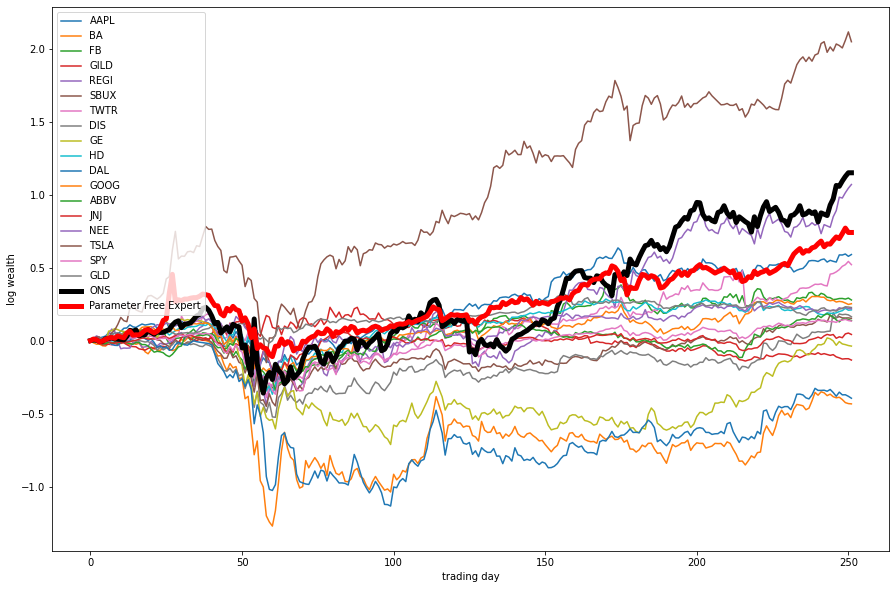

In [11]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

for i, symbol in enumerate(my_stocks):
    ax.plot(np.arange(T),np.log(stocks[i]) - np.log(stocks[i,0]), label=symbol)

ax.plot(np.arange(T), log_wealth_ons, 'k' , linewidth=5, label='ONS')
ax.plot(np.arange(T), log_wealth_expert, 'r' , linewidth=5, label='Parameter Free Expert')

ax.legend()
ax.set_xlabel('trading day')
ax.set_ylabel('log wealth')
plt.show()

## Our current portfolio

In [12]:
biggest = np.argsort(x)
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x[i]*100))+ '%')

TSLA	53.9%
REGI	27.1%
GE	5.137%
TWTR	4.715%
AAPL	3.535%
DAL	2.85%
DIS	1.519%
BA	1.251%
ABBV	0.0%
GOOG	0.0%
HD	0.0%
SPY	0.0%
JNJ	0.0%
SBUX	0.0%
NEE	0.0%
GILD	0.0%
FB	0.0%
GLD	0.0%
